<a href="https://colab.research.google.com/github/jufabeck2202/KI-Lab/blob/main/Assignment_3_1_OWCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tasks

1. Train a CNN model using the architecture described here, but without the classes „ship“ and „truck“: 
*  Remove the classes from the train and test data (→ write a custom dataset)
*  Change the last layer of the CNN accordingly

2. After training, save the model to a permanent storage for later re-use.

# Import

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import time

In [2]:
torch.backends.cudnn.enabled = False
GPU_ON = torch.cuda.is_available()
device = torch.device("cuda:0" if GPU_ON else "cpu")
device

device(type='cuda', index=0)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Import Data

In [4]:
from enum import Enum

class Target(Enum):
    Plane = 0
    Car = 1
    Bird = 2
    Cat = 3
    Deer = 4
    Dog = 5
    Frog = 6
    Horse = 7
    Ship = 8
    Truck = 9

In [5]:
class NewCifar(Dataset):

    def __init__(self, orignalCifar, targets):
        self.newCifar = []

        for i in range(len(orignalCifar)):
            if orignalCifar.targets[i] in targets:
                self.newCifar.append(orignalCifar[i])


    def __len__(self):
        return len(self.newCifar) # 1000 per calss

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx= idx.tolist()

        return self.newCifar[idx]

In [6]:
targets = [Target.Plane.value, Target.Car.value, Target.Bird.value, 
           Target.Cat.value, Target.Deer.value, Target.Dog.value, 
           Target.Frog.value, Target.Horse.value]
           
targets

[0, 1, 2, 3, 4, 5, 6, 7]

In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
targets
trainset = NewCifar(torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform), targets)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                        shuffle=True, num_workers=2)

testset = NewCifar(torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform), targets)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(len(testset))

Files already downloaded and verified
Files already downloaded and verified
8000


#Show Images

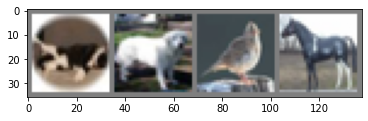

  cat   dog  bird horse


In [8]:

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Network

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, len(targets))           # reduced from 10 to 8 because of no ship and truck

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

if GPU_ON:
  net.cuda()

#Loss function and optimizer

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

#Train

In [11]:
duration = time.time()

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        if GPU_ON:
          inputs = inputs.cuda()
          labels = labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

duration = time.time() - duration
print("--- " + ("GPU" if GPU_ON else "CPU") + ": %s seconds ---" % (duration))

[1,  2000] loss: 2.002
[1,  4000] loss: 1.684
[1,  6000] loss: 1.503
[1,  8000] loss: 1.429
[1, 10000] loss: 1.375
[2,  2000] loss: 1.320
[2,  4000] loss: 1.281
[2,  6000] loss: 1.252
[2,  8000] loss: 1.232
[2, 10000] loss: 1.209
Finished Training
--- GPU: 83.74976754188538 seconds ---


#Save Model

In [14]:
PATH = '/content/drive/My Drive/Public/KILAB/A3/CIFAR8_NET.pth'
torch.save(net.state_dict(), PATH)